In [1]:
import nilearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nilearn.image import new_img_like, load_img
from nilearn.plotting import plot_surf_roi, plot_roi
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf
from scipy import stats
import os
# use black background for matplotlib
plt.style.use('dark_background')

In [2]:
parcels_list = ['Events_original', 'Langugage', 'MD', 'DMN']

In [3]:
import matplotlib as mpl
from warnings import warn
from nilearn.surface import load_surf_data, load_surf_mesh, vol_to_surf

def _compute_facecolors_matplotlib(bg_map, faces, n_vertices,
                                   darkness, alpha):
    """Help for plot_surf with matplotlib engine.

    This function computes the facecolors.
    """
    if bg_map is None:
        bg_data = np.ones(n_vertices) * 0.5
    else:
        bg_data = np.copy(load_surf_data(bg_map))
        if bg_data.shape[0] != n_vertices:
            raise ValueError('The bg_map does not have the same number '
                             'of vertices as the mesh.')

    bg_faces = np.mean(bg_data[faces], axis=1)
    # scale background map if need be
    # bg_vmin, bg_vmax = np.min(bg_faces), np.max(bg_faces)
    bg_vmin, bg_vmax = -5, 5
    if (bg_vmin < 0 or bg_vmax > 1):
        bg_norm = mpl.colors.Normalize(vmin=bg_vmin, vmax=bg_vmax)
        bg_faces = bg_norm(bg_faces)

    if darkness is not None:
        bg_faces *= darkness
        warn(
            (
                "The `darkness` parameter will be deprecated in release 0.13. "
                "We recommend setting `darkness` to None"
            ),
            DeprecationWarning,
        )

    face_colors = plt.cm.gray_r(bg_faces)

    # set alpha if in auto mode
    if alpha == 'auto':
        alpha = .5 if bg_map is None else 1
    # modify alpha values of background
    face_colors[:, 3] = alpha * face_colors[:, 3]

    return face_colors

nilearn.plotting.surf_plotting._compute_facecolors_matplotlib = _compute_facecolors_matplotlib

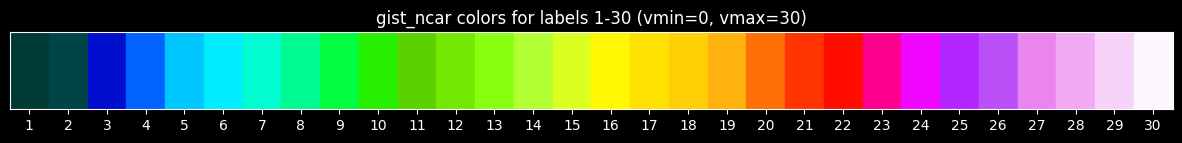

In [4]:
import matplotlib.pyplot as plt
import numpy as np
N = 30

# Define colormap and normalization
cmap = plt.get_cmap('gist_ncar')
norm = plt.Normalize(vmin=0, vmax=N)

# Generate colors for labels 1 through 20
labels = np.arange(1, N+1)
colors = cmap(norm(labels))

# Plot as a color bar
fig, ax = plt.subplots(figsize=(N//2, 1))
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, N)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0.5, N+0.5, 1))
ax.set_xticklabels(labels)
ax.set_yticks([])
ax.set_title(f'gist_ncar colors for labels 1-{N} (vmin=0, vmax={N})')
plt.show()


In [5]:
colors = {
    'Events': 16, 'Language': 22, 'DMN': 11, 'MD': 3,
}

def get_data(task):
    img = load_img(f'{task}.nii')
    data = img.get_fdata()
    data = data > 0
    # TODO remove ang in langauge network
    return new_img_like(img, data * colors[task.split('_')[0]])

In [6]:
fsaverage = fetch_surf_fsaverage('fsaverage5')
from nilearn.surface import load_surf_data


def plot_surf(data, view="lateral", hemi="left", title=None,
              inflate=False, figure=None, bg_map=True, ax=None):
    surf_data = {
        "left": vol_to_surf(data, fsaverage.white_left, 
                            # kind='ball',
                            depth=[-1., 0.],
                            interpolation='nearest', radius=0),
        "right": vol_to_surf(data, fsaverage.white_right, 
                            #  kind='ball',
                             depth=[-1., 0.],
                             interpolation='nearest', radius=0),
    }

    bg = load_surf_data(getattr(fsaverage, f"sulc_{hemi}"))

    surf_mesh = f"infl_{hemi}" if inflate else f"pial_{hemi}"
    plot_surf_roi(
        surf_mesh=getattr(fsaverage, surf_mesh),
        roi_map=surf_data[hemi],
        hemi=hemi,
        view=view,
        bg_on_data=False,
        bg_map=bg if bg_map else None,
        darkness=0.8,
        cmap="gist_ncar",
        avg_method='max',
        alpha=1,
        figure=figure,
        vmin=0,
        vmax=30,
        axes=ax,
        title=title
    )

/var/folders/k0/md38zs8x1395ywbtngppz3k00000gp/T/ipykernel_34472/251972316.py:10: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, data * colors[task.split('_')[0]])
/var/folders/k0/md38zs8x1395ywbtngppz3k00000gp/T/ipykernel_34472/916039470.py:29: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  warn(
/var/folders/k0/md38zs8x1395ywbtngppz3k00000gp/T/ipykernel_34472/251972316.py:10: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been conve

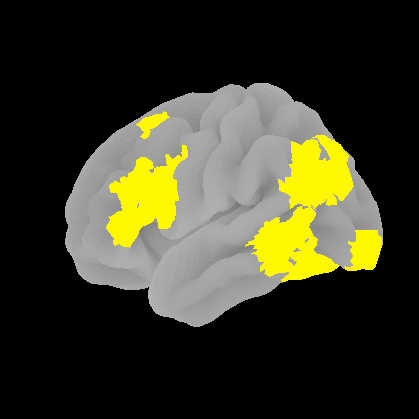

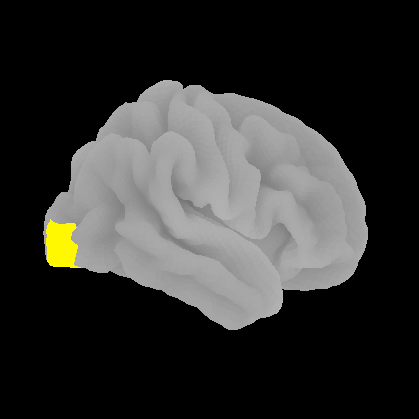

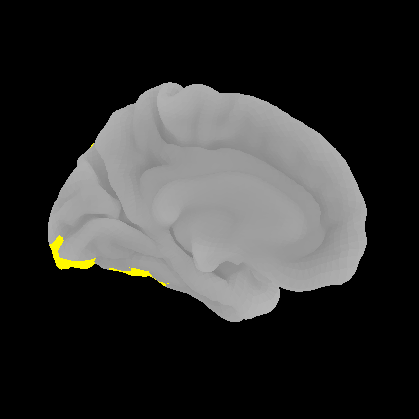

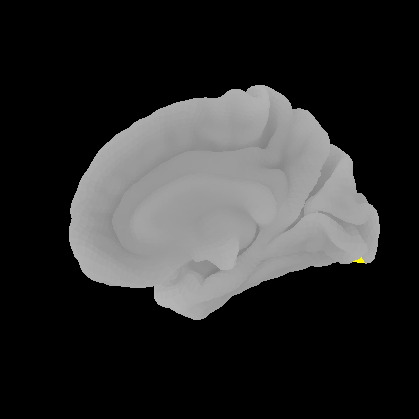

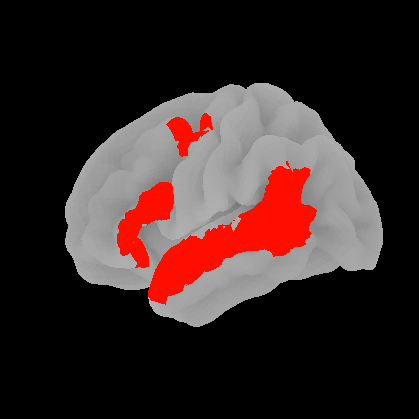

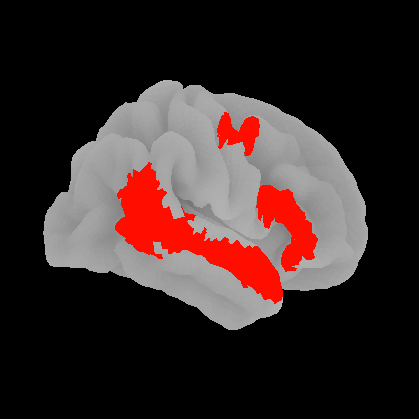

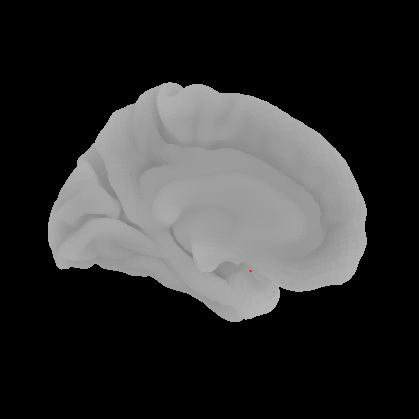

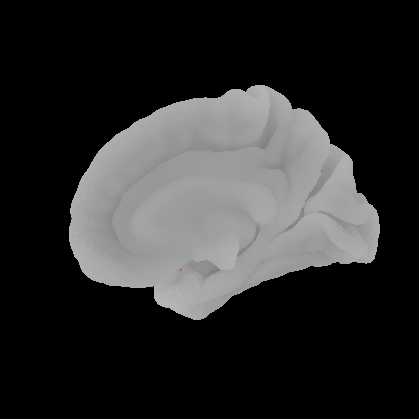

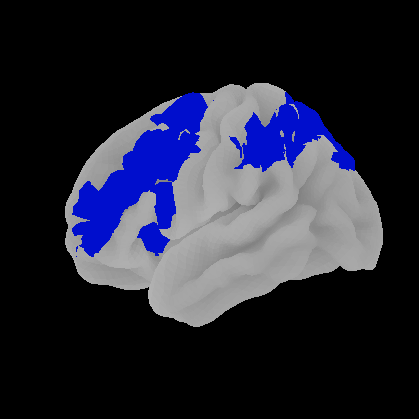

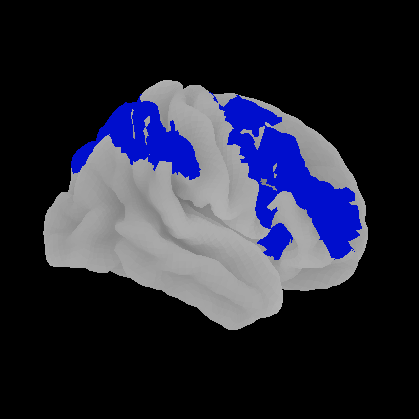

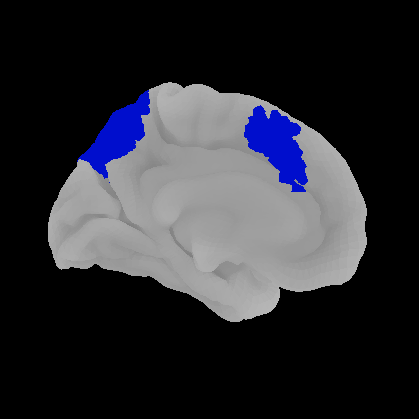

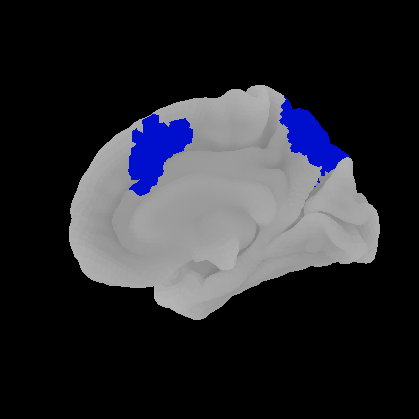

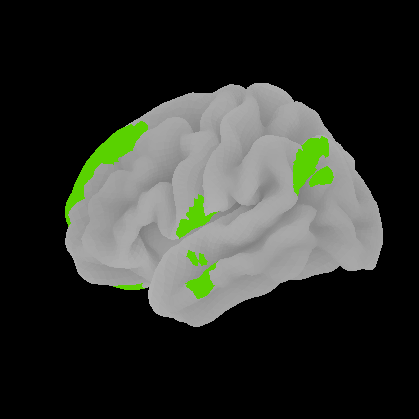

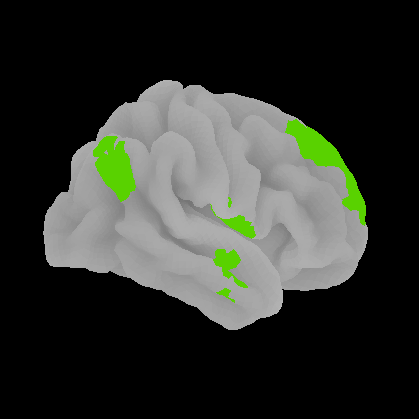

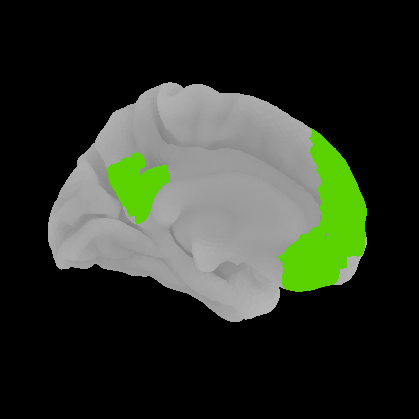

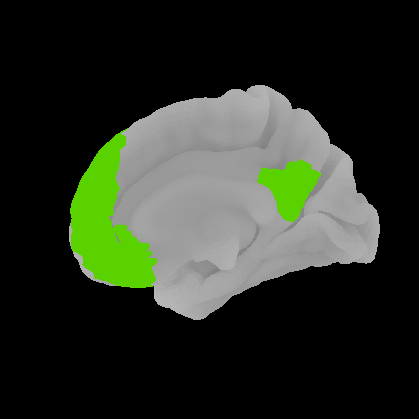

In [8]:
for parcels in ['Events_original', 'Language', 'MD', 'DMN']:
    for view in ["lateral", 'medial']:
        for hemi in ["left", "right"]:
            img = get_data(parcels)
            plot_surf(img, inflate=False, view=view, hemi=hemi)
            plt.savefig(f'Figures/{parcels}_{view}_{hemi}.png', dpi=300, bbox_inches='tight',
                        transparent=True)   